### **About the Project**

Predicting home prices in Bangalore based on features like Location, Number of Bedrooms and Bathrooms, Area etc.

### **Import Libraries**

In [446]:
import os
import numpy as np 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv


In [447]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,10)
import warnings
warnings.filterwarnings('ignore')

### **Load the Dataset**

In [448]:
df1 = pd.read_csv('/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


### **Understanding The Data**

In [449]:
df1.shape

(13320, 9)

In [450]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [451]:
df1.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

Examine the columns.

In [452]:
df1['availability'].value_counts()

Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
                 ...  
15-Aug               1
17-Jan               1
16-Nov               1
16-Jan               1
14-Jul               1
Name: availability, Length: 81, dtype: int64

In [453]:
df1["area_type"].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

For simplicity I am dropping availability, balcony and society columns.

In [454]:
df1.drop(['availability','society','balcony'],axis=1,inplace=True)

In [455]:
df1.columns

Index(['area_type', 'location', 'size', 'total_sqft', 'bath', 'price'], dtype='object')

### **Data Cleaning**

Let us handle the missing values first.

In [456]:
df1.isna().sum()

area_type      0
location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [457]:
df1['size'] = df1['size'].fillna(df1['size'].mode()[0])

In [458]:
df1.drop(labels = df1[df1['bath'].isna() == True].index , inplace = True)

In [459]:
df1.drop(labels = df1[df1['location'].isna() == True].index, inplace = True)

In [460]:
df1.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [461]:
df1.shape

(13246, 6)

In [462]:
df1['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

The category 4 Bedroom and 4BHK are same. To solve this let us create a new column BHK.


In [463]:
df1['bhk'] = df1['size'].apply(lambda x:int(x.split()[0]))
df1['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

Looking the no of bedrooms we find entries like 43, 27 etc. let us look those rows.

In [464]:
df1[df1['bhk']>20]

,area_type,location,size,total_sqft,bath,price,bhk
1718,Super built-up Area,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Plot Area,Munnekollal,43 Bedroom,2400,40.0,660.0,43


43 bedrooms at 2400sqft area doesn't make any sense. It is an error. Before cleaning this up I want to clean the total_sqft column.

In [465]:
df1['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

Not all values in the total_sqft column is a single number. It has values which are in range format. Let us first extract them and convert them into a single value.

In [466]:
def cnvt_sqft(x):
    token = x.split('-')
    if len(token) == 2:
        return (float(token[0])+float(token[1]))/2
    try:
        return float(x)
    except:
        return None

In [467]:
df1['total_sqft'] = df1['total_sqft'].apply(cnvt_sqft)

In [468]:
df1['total_sqft'].unique()

array([1056. , 2600. , 1440. , ..., 1258.5,  774. , 4689. ])

In [469]:
df1 = df1[~df1['total_sqft'].isnull()]
df1.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

### **Feature Engineering**

In [470]:
df2 = df1.copy()

In [471]:
df2.head()

,area_type,location,size,total_sqft,bath,price,bhk
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Built-up Area,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Super built-up Area,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [472]:
df2['price_per_sqft'] = (df2['price']*100000)/df2['total_sqft']

In [473]:
df2.head()

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Built-up Area,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Super built-up Area,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


Let us explore location column.

In [474]:
df2['location'].unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [475]:
len(df2['location'].unique())

1298

Too many locations to handle.

First clean up the location column by removing extra spaces.

In [476]:
df2['location'] = df2['location'].apply(lambda x:x.strip())

In [477]:
location_stats = df2['location'].value_counts()
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

Any location with less than 10 data points is called Other.

In [478]:
len(location_stats[location_stats < 10])

1033

In [479]:
location_less_than_10 = location_stats[location_stats < 10]

location_less_than_10

2nd Phase JP Nagar           9
Chandra Layout               9
Mathikere                    9
Kaverappa Layout             9
Peenya                       9
                            ..
Rajanna Layout               1
Subramanyanagar              1
Lakshmipura Vidyaanyapura    1
Malur Hosur Road             1
Abshot Layout                1
Name: location, Length: 1033, dtype: int64

In [480]:
len(df2['location'].unique())

1287

In [481]:
df2['location'] = df2['location'].apply(lambda x: "other" if x in location_less_than_10 else x)

In [482]:
len(df2['location'].unique())

255

### **Outlier Removal Using Business Logic**

As we saw before, there are outliers in bhk column. The sqft per bedroom is usually above 300 sqft so anything less than that is an outlier.

In [483]:
df2[df2['total_sqft']/df2['bhk']<300].head()

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,Plot Area,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,Plot Area,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Plot Area,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Plot Area,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,Plot Area,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [484]:
df3 = df2[~(df2['total_sqft']/df2['bhk']<300)]
df3.shape

(12456, 8)

### **Outlier Removal Using Standard Deviation and Mean**

In [485]:
df3.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In Bangalore its very unlikely to get a a sqft area with 267Rs. The max value is over 17 lakh, even though this can be possible since we are building a generic model it is good to remove it.

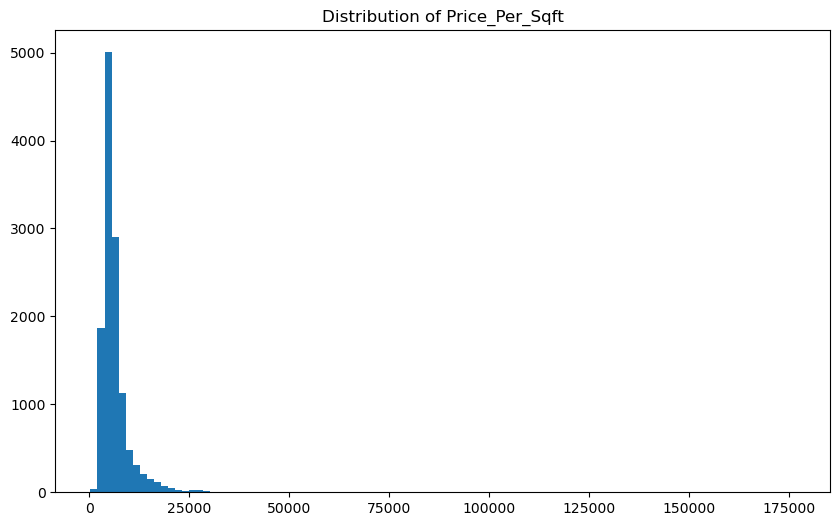

In [486]:
plt.figure(figsize=(10,6))
plt.hist(df3["price_per_sqft"],bins=100)
plt.title("Distribution of Price_Per_Sqft")
plt.show()

I am considering anything above or below 1 standard deviation as outlier. I need to group by location since each location has different price range.

In [487]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key,i in df3.groupby('location'):
         m = np.mean(i.price_per_sqft)
         sd = np.std(i.price_per_sqft)
         reduce_df = i[((i.price_per_sqft > (m-sd)) & (i.price_per_sqft < (m+sd)))]
         df_out = pd.concat([df_out,reduce_df], ignore_index = True)
    return df_out
   
    


In [488]:
df4 = remove_pps_outliers(df3)
df4.price_per_sqft.describe()

count    10222.000000
mean      5667.702604
std       2293.652818
min       1250.000000
25%       4249.118840
50%       5175.792088
75%       6428.571429
max      24509.803922
Name: price_per_sqft, dtype: float64

In [489]:
df4.shape

(10222, 8)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

In [490]:
def scatter_plot(df,location):
    bhk2 = df4[(df4.location == location) & (df4.bhk == 2)]
    bhk3 = df4[(df4.location == location) & (df4.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft , bhk2.price, color = 'red', label = '2BHK', s= 50)
    plt.scatter(bhk3.total_sqft, bhk3.price, color = 'green', marker = '*', label = '3BHK', s = 50)
    plt.xlabel('Total Sqft Area')
    plt.ylabel("Price(in Lakh Rupees)")
    plt.title(location)
    plt.legend()
    plt.show()
    


In [491]:
df4.location.unique()

array(['1st Block Jayanagar', '1st Block Koramangala',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout',
       '5th Phase JP Nagar', '6th Phase JP Nagar', '7th Phase JP Nagar',
       '8th Phase JP Nagar', '9th Phase JP Nagar', 'AECS Layout',
       'Abbigere', 'Akshaya Nagar', 'Ambalipura', 'Ambedkar Nagar',
       'Amruthahalli', 'Anandapura', 'Ananth Nagar', 'Anekal',
       'Anjanapura', 'Ardendale', 'Arekere', 'Attibele', 'BEML Layout',
       'BTM 1st Stage', 'BTM 2nd Stage', 'BTM Layout', 'Babusapalaya',
       'Badavala Nagar', 'Balagere', 'Banashankari',
       'Banashankari Stage II', 'Banashankari Stage III',
       'Banashankari Stage V', 'Banashankari Stage VI', 'Banaswadi',
       'Banjara Layout', 'Bannerghatta', 'Bannerghatta Road', 'Basapura',
       'Basavangudi', 'Basaveshwara Nagar', 'Battarahalli', 'Begur',
       'Begur Road', 'Bellandur', 'Benson Town', 'Bharathi Nagar',
       'Bhoganhalli', 'Billek

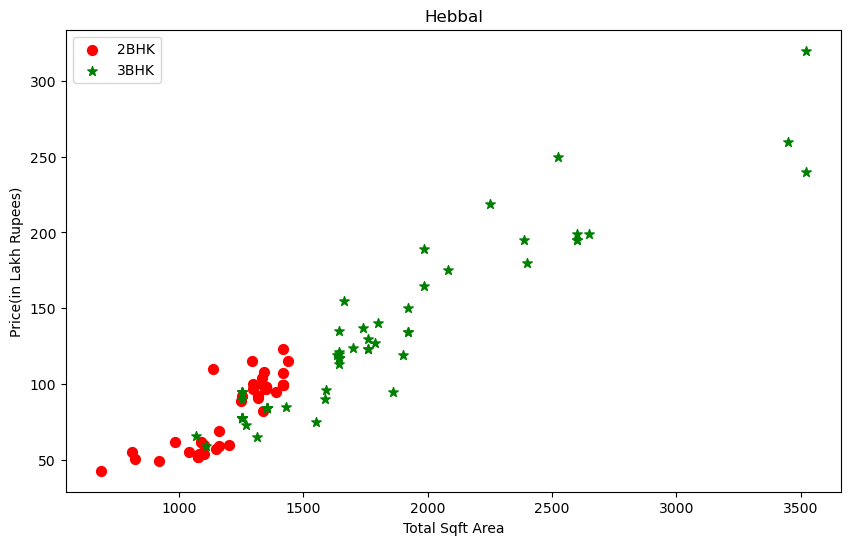

In [492]:
plt.figure(figsize=(10,6))
scatter_plot(df4,'Hebbal')

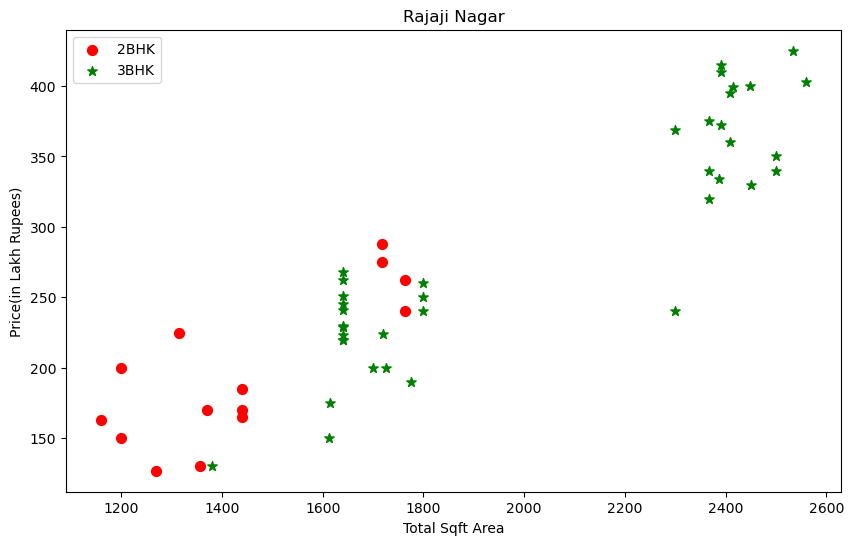

In [493]:
plt.figure(figsize=(10,6))
scatter_plot(df4,'Rajaji Nagar')

As we can see from the scatter plot certain 3bhk homes have less price than 2bhk homes for the same location and area. This is a mismatch and such values should be removed.

In [494]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [495]:
df5 = remove_bhk_outliers(df4)
df5.shape

(7369, 8)

In [496]:
df5

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Super built-up Area,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,Super built-up Area,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,Super built-up Area,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,Built-up Area,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,Super built-up Area,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...,...
10213,Carpet Area,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10214,Super built-up Area,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10217,Super built-up Area,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10218,Plot Area,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


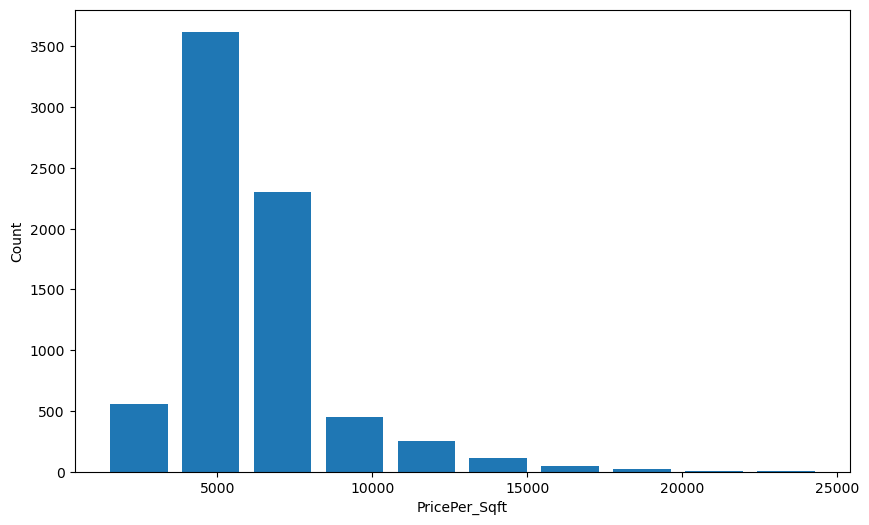

In [497]:
plt.figure(figsize=(10,6))
plt.hist(df5['price_per_sqft'], rwidth = 0.8)
plt.xlabel('PricePer_Sqft')
plt.ylabel('Count')
plt.show()

### **Outlier Removal Using Bathrooms Feature**

In [498]:
df5.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6., 14.,  7.,  9., 12., 16., 13.])

In [499]:
df5[df5['bath']>10]

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft
585,Plot Area,BTM 1st Stage,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
5344,Super built-up Area,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8547,Super built-up Area,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8633,Super built-up Area,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9329,Super built-up Area,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9642,Super built-up Area,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [500]:
df5[df5['bath'] > df5['bhk']+2]

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft
585,Plot Area,BTM 1st Stage,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
1642,Built-up Area,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5305,Built-up Area,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6792,Super built-up Area,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8476,Super built-up Area,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


If you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed.

In [501]:
df6 = df5[df5['bath']<df5['bhk']+2]
df6.shape

(7291, 8)

### **One Hot Encoding**

In [502]:
dummies = pd.get_dummies(df6.location)
dummies1 = pd.get_dummies(df6.area_type)


In [503]:
df7 = pd.concat([df6,dummies.drop('other',axis='columns'),dummies1],axis='columns')
df7

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft,1st Block Jayanagar,1st Block Koramangala,...,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,Super built-up Area,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860,1,0,...,0,0,0,0,0,0,0,0,0,1
1,Super built-up Area,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491,1,0,...,0,0,0,0,0,0,0,0,0,1
2,Super built-up Area,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333,1,0,...,0,0,0,0,0,0,0,0,0,1
3,Built-up Area,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333,1,0,...,0,0,0,0,0,0,1,0,0,0
4,Super built-up Area,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10213,Carpet Area,other,2 BHK,1200.0,2.0,70.0,2,5833.333333,0,0,...,0,0,0,0,0,0,0,1,0,0
10214,Super built-up Area,other,1 BHK,1800.0,1.0,200.0,1,11111.111111,0,0,...,0,0,0,0,0,0,0,0,0,1
10217,Super built-up Area,other,2 BHK,1353.0,2.0,110.0,2,8130.081301,0,0,...,0,0,0,0,0,0,0,0,0,1
10218,Plot Area,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443,0,0,...,0,0,0,0,0,0,0,0,1,0


In [504]:
df7.drop(['area_type','location','size','price_per_sqft'],axis=1,inplace=True)

In [505]:
df7.columns

Index(['total_sqft', 'bath', 'price', 'bhk', '1st Block Jayanagar',
       '1st Block Koramangala', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout',
       ...
       'Whitefield', 'Yelachenahalli', 'Yelahanka', 'Yelahanka New Town',
       'Yelenahalli', 'Yeshwanthpur', 'Built-up  Area', 'Carpet  Area',
       'Plot  Area', 'Super built-up  Area'],
      dtype='object', length=262)

In [506]:
df7.shape

(7291, 262)

### **Model Building**

In [507]:
X = df7.drop('price',axis=1)
y = df7.price

In [508]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [509]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [510]:
from sklearn.metrics import r2_score
y_pred = lr.predict(X_test)
print(lr.score(X_test,y_test))

0.8362059146163534


Use K Fold cross validation to measure accuracy of our LinearRegression model

In [511]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [512]:
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84085802, 0.82811817, 0.90235459, 0.85080899, 0.83693857])

We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

### **Find best model using GridSearchCV**

In [513]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
            }
        },
        'random_forest':{
            'model': RandomForestRegressor(),
            'params':{}
        
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score
0,linear_regression,0.851816
1,random_forest,0.781746
2,lasso,0.705025
3,decision_tree,0.691500


Based on above results we can say that LinearRegression gives the best score. Hence we will use that

In [514]:
price_data = pd.DataFrame({'Actual Price': y_test, 'Predicted Price':lr.predict(X_test)})
price_data.head(10)

,Actual Price,Predicted Price
2213,38.00,17.128736
5886,52.66,68.315854
4518,45.00,41.959816
7500,156.00,147.806426
7053,42.00,38.850963
6628,126.00,137.050350
256,20.00,1.072404
5210,49.65,53.015241
5394,204.00,204.974381
7599,261.00,216.951920


### **Prediction Using Our Model**

In [521]:
def predict_price(location,sqft,bath,bhk,area_type):    
    loc_index = np.where(X.columns==location)[0][0]
    area_index = np.where(X.columns == area_type)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    if area_index >= 0:
        x[area_index] = 1

    return lr.predict([x])[0]

In [523]:
predict_price('1st Phase JP Nagar',1000, 2, 2,'Plot  Area')

93.41628168983249

In [524]:
predict_price('1st Phase JP Nagar',1000, 3, 3,'Plot  Area')

97.49358699786069

In [525]:
predict_price('Indira Nagar',1000, 2, 2,'Plot  Area')

203.13116299631838

In [526]:
predict_price('Indira Nagar',1000, 3, 3,'Plot  Area')

207.20846830434658

### **Export the Model to a Pickle file**

In [520]:
import pickle
with open('Bangalore_home_price_prediction','wb') as p:
    pickle.dump(lr,p)